Link to article containing original code: <url>https://cnvrg.io/pytorch-lstm/</url><br>
Most of the code is different due to mistakes present in original code.

In [67]:
# imports
import torch as torch
import torch.nn as nn
from torch.autograd import Variable 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [68]:
# read processed data
df = pd.read_csv('../../dataframes/monthly_processed.csv', index_col='date', parse_dates=True)
df = df[['fishoil_price_peru']]
df

,fishoil_price_peru
date,
2022-06-01,0.000000
2022-05-01,0.000000
2022-04-01,0.000000
2022-03-01,0.000000
2022-02-01,0.000000
...,...
1985-05-01,0.001269
1985-04-01,-0.343536
1985-03-01,-0.049483


In [69]:
# variable definitions
num_epochs = 1                  # number of epochs
learning_rate = 0.001           # 0.001 lr

seq_length = 36                 # sequence length of sequence given to the LSTM layer
pred_length = 12                # prediction length of output sequence produced by LSTM layer 
                                # (multiples of twelve since there is yearly seasonality)

input_size = len(df.columns)    # number of features (amount of input variables)
output_size = 1                 # size of output (peru fish oil price so just one variable)
hidden_size = 1                 # number of features in hidden state (this number should be treated as a hyperparameter)
num_layers = 1                  # number of stacked lstm layers

num_classes = pred_length       # number of output classes 

In [70]:
# function to create list of sequences of length seq_length
def create_series(data):
    # the amount of time-steps for which we have data
    total_timesteps = len(data)

    # arrays that hold the input sequences and the corresponding target sequences respectively.
    sequencesX, sequencesY = [], []
    if (total_timesteps < seq_length + pred_length):
        # verify that enough time-steps of the data are available to create input sequence with their corresponding targets.
        raise Exception("This dataframe cannot be used to create sequences of length " + str(seq_length + pred_length))
    
    # create all possible sequences of length seq_length and their 
    for i in range(total_timesteps - seq_length - pred_length):
        # append the input sequence
        sequencesX.append(data.iloc[i:(i+seq_length), :])
        # append the corresponding (target) output sequence
        sequencesY.append(data.iloc[(i+seq_length):(i+seq_length+pred_length), 0:1])
    
    # return the sequences
    return np.array(sequencesX), np.array(sequencesY)

In the following code block the X and y sets are created.

The shape of `X` is as follows:<br>
The element `X[s][i][j]` contains the value of the $j$'th input variable (out of the `len(df.columns)` different input variables) at the $i$'th time-step (out of the `seq_length` time-steps in the sequence) for the $s$'th sequence in the data set `X`.<br>

The shape of `y` is as follows:<br>
The element `y[s][i][0]` contains the value of the peru fish oil price (target) at the $i$'th time-step (out of the `pred_length` time-steps in the sequence) for the $s$'th sequence in the data set `y`.<br>
The last zero-index is used because all the values are wrapped in length one arrays.


In [71]:
# split data into train and test sets
# TODO: May also need a validation set to determine optimal hyperparameters
df_train = df[(df.index > "1996-12-01") & (df.index < "2010-01-01")]    # use only past 1997 due to geopolitical changes
df_test = df[df.index >= "2010-01-01"]

# create the sequences to train on
X_train, y_train = create_series(df_train)

# create the sequences to test on
X_test, y_test = create_series(df_test)

# print shapes
print("Training input/output shapes respectively:", X_train.shape, y_train.shape)
print("Testing input/output shapes respectively:", X_test.shape, y_test.shape) 

Training input/output shapes respectively: (108, 36, 1) (108, 12, 1)
Testing input/output shapes respectively: (102, 36, 1) (102, 12, 1)


The datasets are converted to PyTorch tensors and the shapes are printed.<br>
The input shape is of the form `(nr_of_sequences, seq_length, input_size)`.<br>
The output shape is of the form `(nr_of_sequences, pred_length, output_size)`.

If this needs to be reshaped the `torch.reshape(data, shape)` function can be used.

In [72]:
# convert data to pytorch variables
X_train_tensors = Variable(torch.Tensor(X_train))
y_train_tensors = Variable(torch.Tensor(y_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_test_tensors = Variable(torch.Tensor(y_test)) 

# flatten the output tensors to remove unnecassary dimension
y_train_tensors = torch.flatten(y_train_tensors, 1)
y_test_tensors =  torch.flatten(y_test_tensors, 1)

# print shapes
print("Training input/output shapes respectively:", X_train_tensors.shape, y_train_tensors.shape)
print("Testing input/output shapes respectively:", X_test_tensors.shape, y_test_tensors.shape) 

Training input/output shapes respectively: torch.Size([108, 36, 1]) torch.Size([108, 12])
Testing input/output shapes respectively: torch.Size([102, 36, 1]) torch.Size([102, 12])


The input size of the first fully connected layer is equal to `(hidden_size * seq_length)` because the LSTM outputs the hidden state (containing `hidden_size` variables) for every time-step in the input which contains `seq_length` time-steps. The output size of this layer is a hyperparameter for which a default of twice the amount of inputs is used.

The lstm layer can also use an initial hidden state and initial cell state for each time-step in the sequence of `seq_length` but since these are not provided it defaults to zero.<br>
See the input section of the <a url=https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>documentation</a> for more information.

The output of the lstm layer is `output, (output_hidden_states, output_cell_states)` where `output` contains for every sequence in the provided `input` the hidden state at each time-step.<br>
Furthermore, `output_hidden_states` and `output_cell_states` contain for every sequence the hidden state and cell state of the last time-step, respectively.

In [73]:
# definition of LSTM model
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes      # number of classes
        self.num_layers = num_layers        # number of layers
        self.input_size = input_size        # input size
        self.hidden_size = hidden_size      # hidden state

        fc_1_input_size = hidden_size * seq_length
        fc_1_output_size = hidden_size * seq_length // 2     # output size of first fully connected layer (hyperparameter)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 = nn.Linear(fc_1_input_size, fc_1_output_size) # first fully connected layer
        self.fc_2 = nn.Linear(fc_1_output_size, num_classes) # second fully connected layer

        self.relu = nn.ReLU()
    
    def forward(self, input):
        # propagate input through LSTM
        output, (output_hidden_states, output_cell_states) = self.lstm(input) # retrieve output from lstm by providing input (the initial hidden and cell states can be set but default sets to zero)
        flattened_output = torch.flatten(output) # flattened output
        out = self.relu(flattened_output) # relu
        out = self.fc_1(out) # first fully connected layer
        out = self.relu(out) # relu
        out = self.fc_2(out) # second fully connected layer
        return out

In [74]:
# instantiate the model 
model = LSTM(num_classes, input_size, hidden_size, num_layers) # lstm layer

# model = nn.Sequential(nn.Linear(seq_length * input_size, seq_length),
#                       nn.ReLU(),
#                       nn.Linear(seq_length, num_classes))

In [75]:
# define the loss function and weight updating method
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [76]:
# train the model
for epoch in range(num_epochs):
  # using batches of size 1
  for sequence in range(X_train_tensors.size(0)):
    output = model.forward(X_train_tensors[sequence]) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = criterion(output, y_train_tensors[sequence])
  
    loss.backward() # calculates the loss of the loss function
  
    optimizer.step() # improve from loss, i.e backprop
  if epoch % 10 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.16526


The past baseline predicts that the next 12 months of fish oil log ratios will be exactly those observed last year.<br>
The repeat baselines predicts that the next 12 months of fish oil log ratios will all be equal to the last observed fish oil log ratio.

In [77]:
# make predictions for the test set using lstm and baseline models and compute the losses
lstm_outputs = []
baseline_past_outputs = []
lstm_losses = []
baseline_past_losses = []

# first sequence in test set are not used to ease baseline computation
for sequence in range(1, X_test_tensors.size(0)):
    # output of lstm layer
    lstm_output = model.forward(X_test_tensors[sequence])

    # output of baseline using past data
    baseline_past_output = y_test_tensors[sequence-pred_length]

    # compute losses
    loss_lstm = criterion(lstm_output, y_test_tensors[sequence])
    loss_baseline_past = criterion(baseline_past_output, y_test_tensors[sequence])

    # save the outputs
    lstm_outputs.append(lstm_output.detach().numpy())
    baseline_past_outputs.append(baseline_past_output.numpy())

    # save the losses
    lstm_losses.append(loss_lstm.detach().numpy())
    baseline_past_losses.append(loss_baseline_past.numpy())

Model loss: 0.14615741
Baseline past loss: 0.17305915


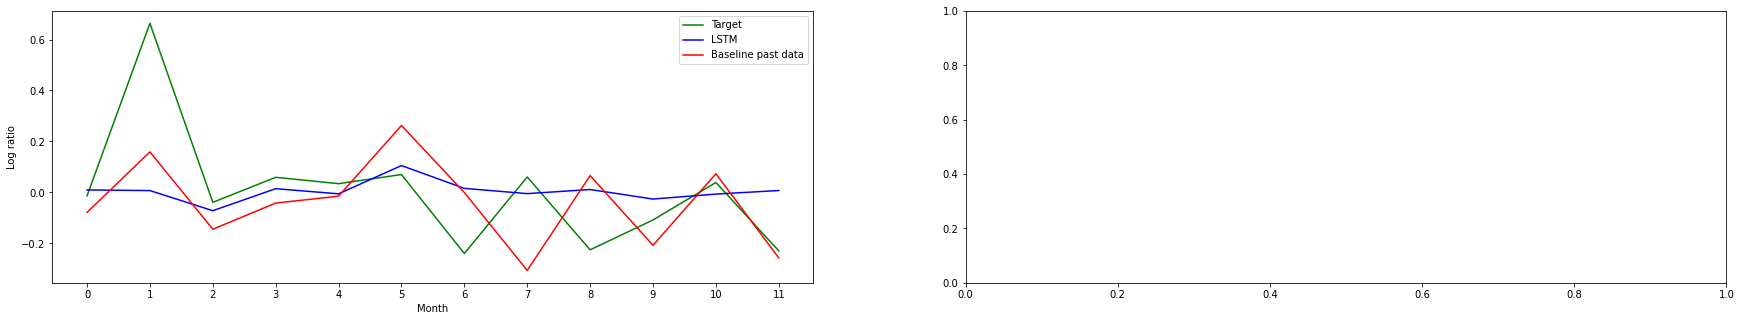

In [86]:
# get a random sequence from the test set
random_test_sequence = random.randint(1, X_test_tensors.size(0) - 1)

# plot lstm and baseline outputs for the random sequence and compare to expected output
data = {'Target': y_test_tensors[random_test_sequence].numpy(), 'LSTM': lstm_outputs[random_test_sequence-1], 'Baseline past data': baseline_past_outputs[random_test_sequence-1]}
df_performance = pd.DataFrame(data)

# plot all data
fig, axs = plt.subplots(1, 2, figsize=(30, 5))

df_performance.plot(kind='line', y='Target', color='green', ax=axs[0])
df_performance.plot(kind='line', y='LSTM', color='blue', ax=axs[0])
df_performance.plot(kind='line', y='Baseline past data', color='red', ax=axs[0])
axs[0].set(xlabel='Month', ylabel='Log ratio')
axs[0].set_xticks(np.arange(0, pred_length, 1))

# print losses 
print("Model loss:", lstm_losses[random_test_sequence-1])
print("Baseline past loss:", baseline_past_losses[random_test_sequence-1])

LSTM loss: 0.1736068
Baseline past loss: 0.2295297


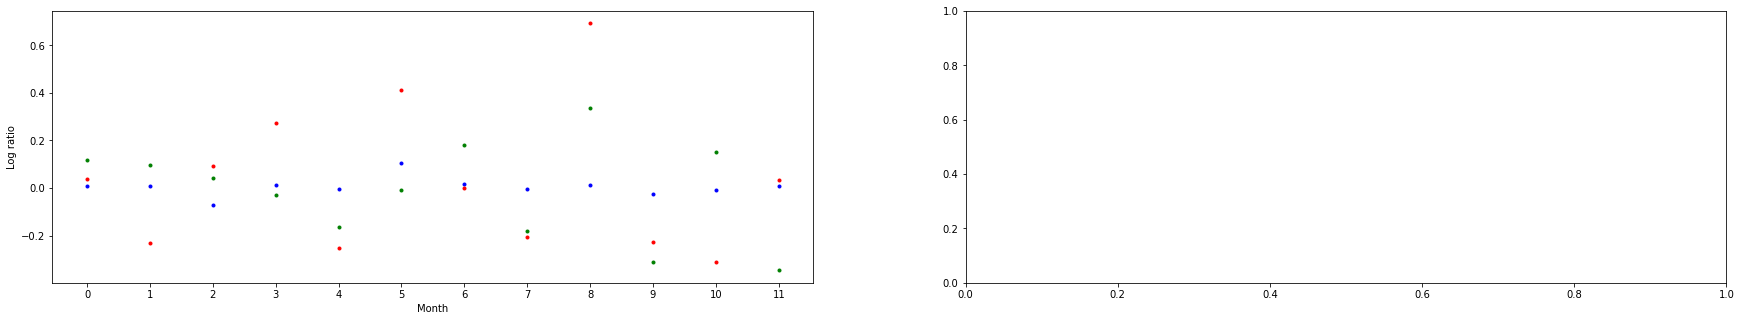

In [79]:
# get a random sequence from the test set
random_test_sequence = random.randint(1, X_test_tensors.size(0) - 1)

# plot lstm and baseline outputs for the random sequence and compare to expected output
data = {'Target': y_test_tensors[random_test_sequence].numpy(), 'LSTM': lstm_outputs[random_test_sequence-1], 'Baseline past data': baseline_past_outputs[random_test_sequence-1]}
df_performance = pd.DataFrame(data)

# plot all data
fig, axs = plt.subplots(1, 2, figsize=(30, 5))

for (model, color) in zip(['Target', 'LSTM', 'Baseline past data'], ['green', 'blue', 'red']):
    for i in range(len(data[model])):
        output = data[model][i]
        axs[0].plot(i, output, color=color,
                marker = '.',
                markerfacecolor=color,
                markeredgecolor=color,
                fillstyle = 'full',
                label=i)
axs[0].set(xlabel='Month', ylabel='Log ratio')
axs[0].set_xticks(np.arange(0, 12, 1))

# print losses 
print("LSTM loss:", lstm_losses[random_test_sequence-1])
print("Baseline past loss:", baseline_past_losses[random_test_sequence-1])

Possible factors holding back model performance:
- provided features do not give enough information 
- target output could be wrong (prediction length)
- layers of the model do not extract information from the features correctly
    - no use of normalization between layers
    - wrong layers are used and possibly too few
    - wrong hyperparameter values are used
- training is not done correctly   
    - no useage of batches
    - different loss function may be better
